# Tarea 2 Computer Vision

## Parte 1: Object Detection

La detección de objetos es una tarea de visión por computadora en la que el objetivo es detectar y localizar objetos de interés en una imagen o vídeo. La tarea consiste en identificar la posición y los límites de los objetos en una imagen y clasificarlos en diferentes categorías. Forma una parte crucial del reconocimiento de la visión, junto con la clasificación y recuperación de imágenes.

![OD](https://miro.medium.com/v2/resize:fit:828/format:webp/1*IrptRDRG8IL9o-55BKjbLA.png)

### Bounding Boxes

Las Bounding Boxes son rectángulos que se dibujan alrededor de los objetos de interés en una imagen. Estos cuadros se utilizan para representar la posición de un objeto en una imagen. Existen varias formas para delimitar los objetos, pero las más comun es calcular 2 puntos X,Y en la esquina superior izquierda y en la esquina inferior derecha respectivamente.

![BB](https://miro.medium.com/v2/resize:fit:640/format:webp/1*yvPdthNNOJfmcYKsDhJJtQ.jpeg)

### Dataset

El Dataset utilizado será Caltech101 [https://data.caltech.edu/records/mzrjq-6wc02] que contiene imágenes de 101 categorías de objetos (por ejemplo, "helicóptero", "elefante" y "silla", etc.) y una categoría de fondo que contiene imágenes que no pertenecen a las 101 categorías de objetos. Para cada categoría de objeto, hay entre 40 y 800 imágenes, mientras que la mayoría de las clases tienen alrededor de 50 imágenes. La resolución de la imagen es aproximadamente de 300×200 píxeles.

Este Dataset tiene incluida las anotaciones de las bounding Boxes de cada imagen, por lo que sera bastante fácil poder implementar un modelo de detección de objetos.

![img_caltech](caltech-101/101_ObjectCategories/airplanes/image_0005.jpg)

### 1.1 Imports

In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import matplotlib.patches as patches

### 1.2 Carga de Datos

In [2]:
# Path de las imágenes y anotaciones
path_images = "caltech-101/101_ObjectCategories/airplanes/"
path_annot = "caltech-101/Annotations/Airplanes_Side_2/"

image_size = 224  # tamaño a redimensionar las imágenes

### 1.3 Preprocesamiento de Imágenes

In [3]:
def preprocess_image(path_images, path_annot, image_size):

    # almacenamos todas las imagenes y sus labels en listas
    image_paths = [f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))]
    annot_paths = [f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))]
    image_paths.sort()
    annot_paths.sort()

    images, targets = [], []

    # iteramos sobre las imagenes y sus labels
    for i in range(0, len(annot_paths)):

        # cargamos las bounding boxes
        annot = scipy.io.loadmat(path_annot + annot_paths[i])["box_coord"][0]

        # extraemos las coordenadas de las bounding boxes
        x1, y1 = annot[2], annot[0]
        x2, y2 = annot[3], annot[1]

        # cargamos la imagen
        image = keras.utils.load_img(path_images + image_paths[i])

        # obtenemos el tamaño de la imagen
        (w, h) = image.size[:2]

        # reescalamos la imagen
        image = image.resize((image_size, image_size))

        # convertimos la imagen a un array y la almacenamos en la lista
        images.append(keras.utils.img_to_array(image))

        # normalizamos las coordenadas de las bounding boxes
        targets.append(
            (
                float(x1) / w,
                float(y1) / h,
                float(x2) / w,
                float(y2) / h,
            )
    )

    # convertimos las listas a arrays para el conjunto de entrenamiento y test (80% y 20% respectivamente)
    (x_train), (y_train) = (
        np.asarray(images[: int(len(images) * 0.8)]),
        np.asarray(targets[: int(len(targets) * 0.8)]),
    )

    (x_test), (y_test) = (
        np.asarray(images[int(len(images) * 0.8) :]),
        np.asarray(targets[int(len(targets) * 0.8) :]),
    )

    return (x_train, y_train), (x_test, y_test)

In [4]:
(x_train, y_train), (x_test, y_test) = preprocess_image(path_images, path_annot, image_size)

### 1.4 Vision Transformer (ViT)

Vision Transformer, o ViT [https://arxiv.org/abs/2010.11929], es un modelo para clasificación de imágenes que emplea una arquitectura similar a Transformer sobre parches de la imagen. Una imagen se divide en parches de tamaño fijo, luego esos parches se proyectan linealmente a través de una capa de embedding, se agregan los embedding de la posición y la secuencia resultante de vectores es el input de nuestro bloque encoder del Transformer. Por ultimo se agrega un cabezal MLP para la clasificacion, pero en este caso en vez de clasificar las imágenes, haremos la prediccion de las bounding boxes.

![ViT](https://learnopencv.com/wp-content/uploads/2023/02/image-9-1536x807.png)

Por ultimo Notar que ViT se puede utilizar para varios problemas, no solo clasificacion de imagenes como lo presentan en el Paper, en este caso lo estamos utilizando para deteccion de objetos y es por eso que cambiamos la capa final del modelo, para que en vez de tener una capa con activacion softmax para predecir la clase, ahora tenemos una capa con 4 neuronas para predecir las 4 coordenadas de la bounding box.

#### 1.4.1 Visualización de Parches

In [5]:
class Patches(keras.layers.Layer): #Clase para extraer los parches de las imágenes
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size #Tamaño de los parches

    def call(self, images): #Función para extraer los parches de las imágenes
        batch_size = tf.shape(images)[0] #Tamaño del batch
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1], #Tamaño de los parches
            strides=[1, self.patch_size, self.patch_size, 1], #Tamaño del salto entre parches
            rates=[1, 1, 1, 1], #Tamaño de la ventana
            padding="VALID", #Tipo de padding
        )

        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]]) #Devolvemos los parches como una secuencia para que el modelo pueda procesarlos

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


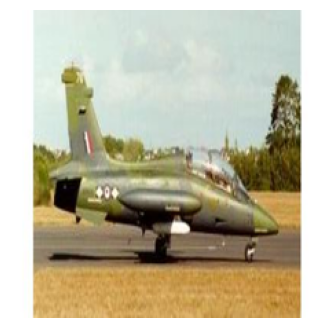

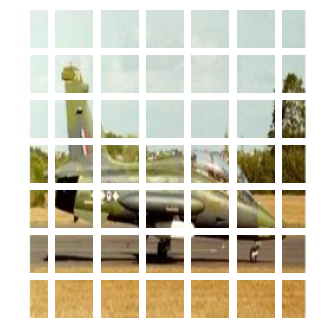

In [6]:
patch_size = 32  # tamaño de los parches

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]])) #Utilizamos la clase Patches para extraer los parches de la imagen
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

n = int(np.sqrt(patches.shape[1])) #Número de parches a mostrar
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

#### 1.4.2 Patch Encoder

El enconder de los parches es una parte fundamental de nuestro modelo, ya que le da continuidad y orden a los parches de la imagen, si por el contrario no utilizaramos los embeddings de la poscicion de cada parche, el modelo juntaria los parches de manera aleatoria y la imagen resultante no tendria coherencia ni sentido, es por esto que utilizar la informacion de la posicion de cada parche es fundamental para el buen funcionamiento del modelo.

In [7]:
class PatchEncoder(keras.layers.Layer): #Clase para codificar los parches
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches                              #Número de parches
        self.projection = keras.layers.Dense(units=projection_dim)  #Capa densa para codificar los parches
        self.position_embedding = keras.layers.Embedding(input_dim=num_patches, output_dim=projection_dim) #Capa de embedding para codificar la posición de los parches

    def call(self, patch): #Función para codificar los parches
        positions = tf.range(start=0, limit=self.num_patches, delta=1) #Creamos un vector con la posición de los parches
        encoded = self.projection(patch) + self.position_embedding(positions) #Concatemanos los embeddings de los parches con los embeddings de su posición
        return encoded

#### 1.4.3 MLP

In [8]:
def mlp(x, hidden_units, dropout_rate): #Función para crear la capa MLP

    #Iteramos sobre las unidades de la capa
    for units in hidden_units:
        #Añadimos una capa densa con activación gelu
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        #Añadimos una capa de dropout
        x = keras.layers.Dropout(dropout_rate)(x)

    return x

**Pregunta: Que beneficios tiene GeLU por sobre ReLU?**

**Respuesta:** Primero que todo, la función GELU es, a diferencia de ReLU, diferenciable en todo su dominio, lo que facilita el cálculo de las derivadas en el gradiente descendente. Además, la función de activación GELU aproxima la salida a la salida de una función sigmoide cuando el argumento es cercano a 0, y a la función identidad si el argumento es muy grande. Por último, en el paper en el cual la proponen, se demuestra empíricamente que la función GELU tiene un mejor rendimiento en términos de velocidad de convergencia y capacidad de aprendizaje que ReLU y ELU, al menos en los casos de prueba utilizados (procesamiento de lenguaje natural y reconocimiento de imágenes).

Se adjunta link del paper original: https://arxiv.org/pdf/1606.08415v5.pdf

#### 1.4.4 ViT

In [9]:
def ViT(input_shape,patch_size,num_patches,projection_dim,num_heads,transformer_units,transformer_layers,mlp_head_units):

    inputs = keras.layers.Input(shape=input_shape)

    # Creamos los parches
    patches = Patches(patch_size)(inputs)

    # Codificamos los parches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Creamos n capas de encoders
    for _ in range(transformer_layers):

        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization()(encoded_patches)

        #multi-head self-attention layer.
        attention_output = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)

        # Skip connection 1.
        x2 = keras.layers.Add()([x1, attention_output])

        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization()(x2)

        # MLP
        x3 = mlp(x3, transformer_units, 0.1)

        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x2, x3])

    # Hacemos un Flatten de los parches codificados para pasarlos por la capa MLP Final
    representation = keras.layers.LayerNormalization()(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.2)(representation)

    # MLP final Head.
    features = mlp(representation, mlp_head_units, 0.1)

    # Capa densa de 4 unidades para predecir las 4 coordenadas de la bounding box
    bounding_box = keras.layers.Dense(4, activation='linear')(features)

    return keras.Model(inputs=inputs, outputs=bounding_box)

### 1.5 Entrenamiento

#### 1.5.1 Hiperparámetros

In [10]:
batch_size = 32
num_epochs = 100

input_shape = (image_size, image_size, 3)
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]

transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]

#### 1.5.2 Creamos el Vision Transformer

In [11]:
model = ViT(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

#### 1.5.3 Agregamos el optimizador y la funcion de pérdida

In [12]:
adamw_opt = tf.keras.optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=0.004,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=None,
    jit_compile=True,
    name='AdamW',
)

mse_loss = tf.keras.losses.MeanSquaredError(
#    reduction=losses_utils.ReductionV2.AUTO,
    name='mean_squared_error'
)

model.compile(optimizer=adamw_opt, loss=mse_loss)

**Pregunta: Que Busca Solucionar AdamW de Adam?**

**Respuesta:** Busca solucionar el problema dado por incluir el término regularizador en la función de costo, lo que da como resultado que las medias móviles del gradiente y su cuadrado (términos de RMSProp y de SGD con Momentum) rastreen no sólo los gradientes de la función de pérdida, sino que también del término regularizador, lo que provoca que la regularización de los pesos de la red dependa de cuánto cambió el gradiente (lo que no va de la mano con lo que se espera de la regularización).

#### 1.5.4 Creamos nuestro callback de Early Stopping

In [13]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

#### 1.5.5 Entrenamos el modelo

In [14]:
history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=es_callback,
    )

Epoch 1/100
18/18 [==============================] - 14s 336ms/step - loss: 1.3531 - val_loss: 0.0791
Epoch 2/100
18/18 [==============================] - 5s 289ms/step - loss: 0.1134 - val_loss: 0.0236
Epoch 3/100
18/18 [==============================] - 5s 294ms/step - loss: 0.0483 - val_loss: 0.0021
Epoch 4/100
18/18 [==============================] - 5s 292ms/step - loss: 0.0355 - val_loss: 0.0067
Epoch 5/100
18/18 [==============================] - 5s 291ms/step - loss: 0.0260 - val_loss: 0.0039
Epoch 6/100
18/18 [==============================] - 5s 284ms/step - loss: 0.0232 - val_loss: 0.0018
Epoch 7/100
18/18 [==============================] - 5s 291ms/step - loss: 0.0209 - val_loss: 0.0020
Epoch 8/100
18/18 [==============================] - 6s 336ms/step - loss: 0.0195 - val_loss: 0.0022
Epoch 9/100
18/18 [==============================] - 7s 421ms/step - loss: 0.0171 - val_loss: 0.0025
Epoch 10/100
18/18 [==============================] - 7s 406ms/step - loss: 0.0153 - val_l

### 1.6 IoU

Intersection Over Union (IoU) es una métrica de evaluación común para la detección de objetos. Se utiliza para medir la superposición entre el área predicha y el área de destino. La superposición se calcula como el área de intersección entre las áreas predichas y de destino dividida por el área de unión entre las áreas predichas y de destino.

![Foto](https://www.baeldung.com/wp-content/uploads/sites/4/2022/04/fig1.png)

#### 1.6.1 Función de IoU

In [15]:
def bounding_box_intersection_over_union(box_predicted, box_truth): #Función para calcular el IoU entre dos bounding boxes

    # shape: [x1, y1, x2, y2]

    # obtenemos las coordenadas (x, y) de la intersección de las bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculamos el area de la intersección
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(0, bottom_y_intersect - top_y_intersect + 1)

    # calculamos el area de las bounding boxe predicha y real
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (box_predicted[3] - box_predicted[1] + 1)
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (box_truth[3] - box_truth[1] + 1)

    # Calculamos el IoU dividiendo el área de la intersección por la suma del área de las bounding boxes predicha y real menos el área de la intersección
    IoU = intersection_area/(box_predicted_area + box_truth_area - intersection_area)

    # retornamos el IoU
    return IoU

#### 1.6.2 Visualización de IoU

1/1 [==============================] - 0s 44ms/step
mean_iou: 0.8555395888461531


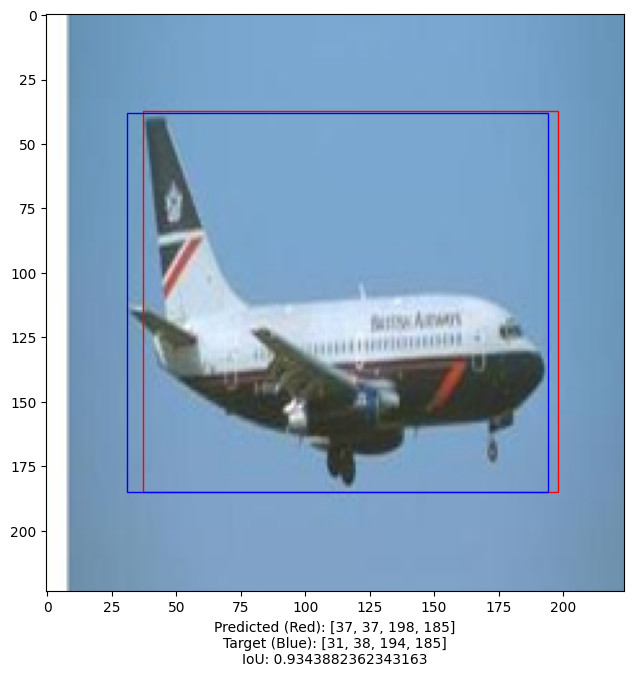

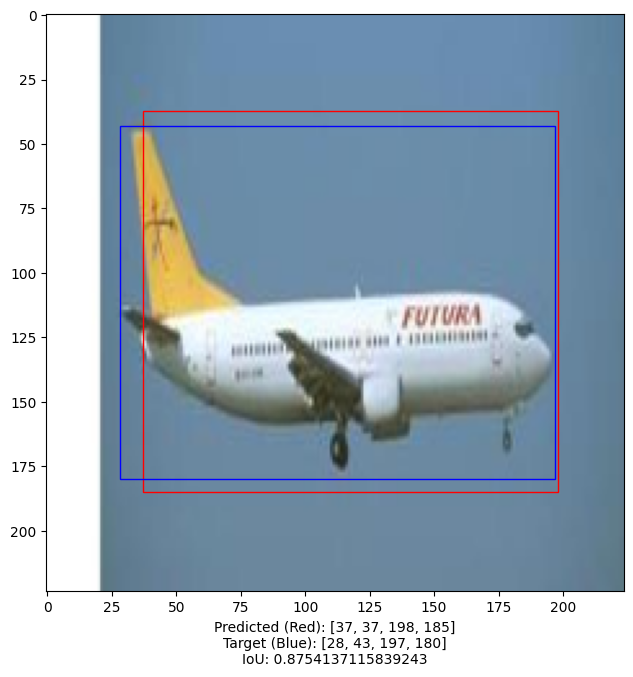

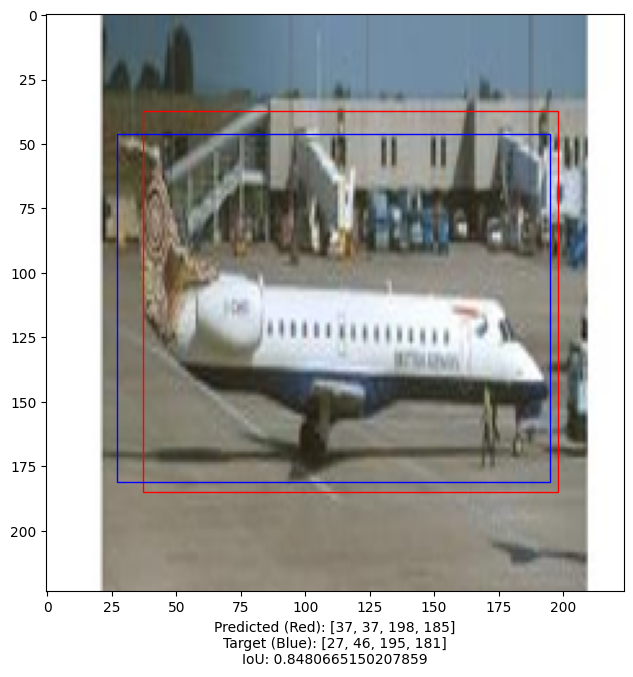

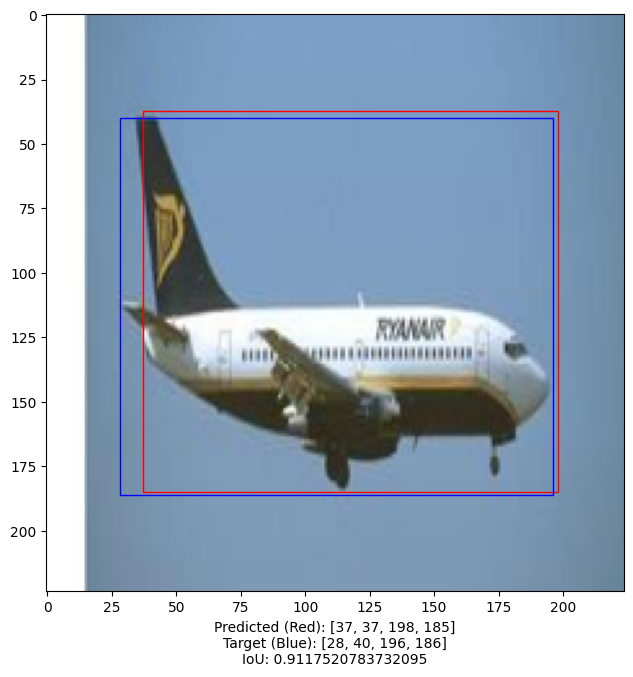

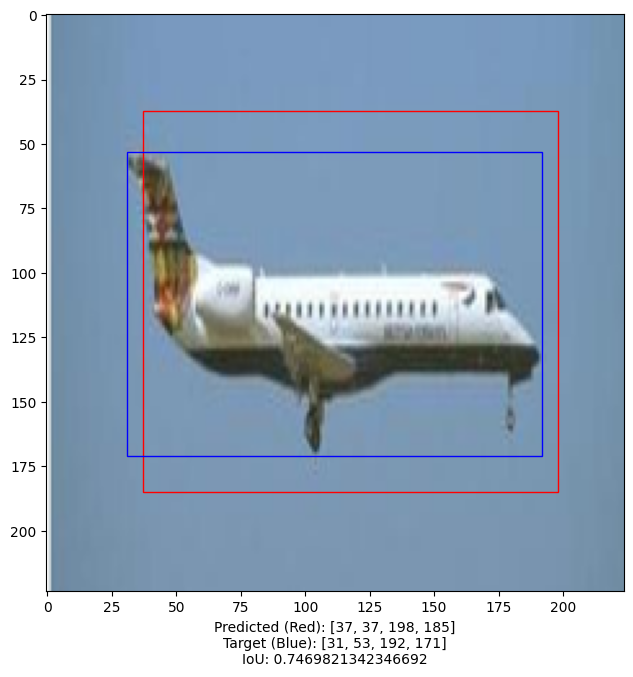

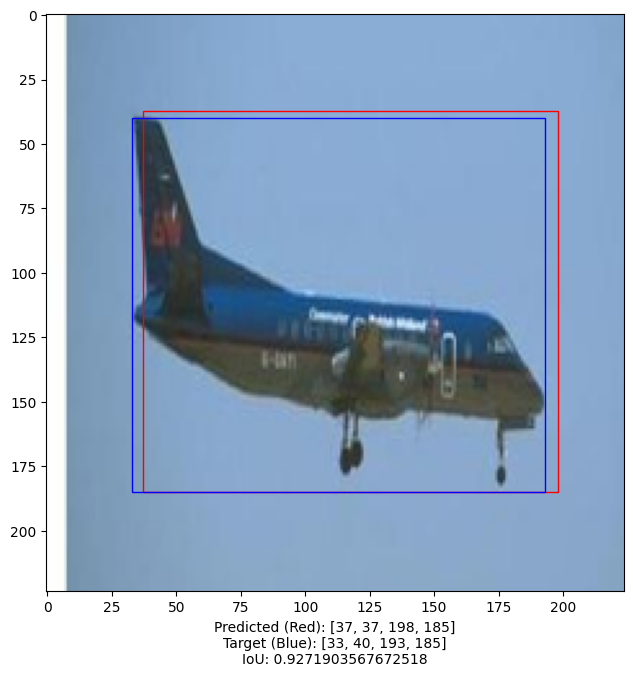

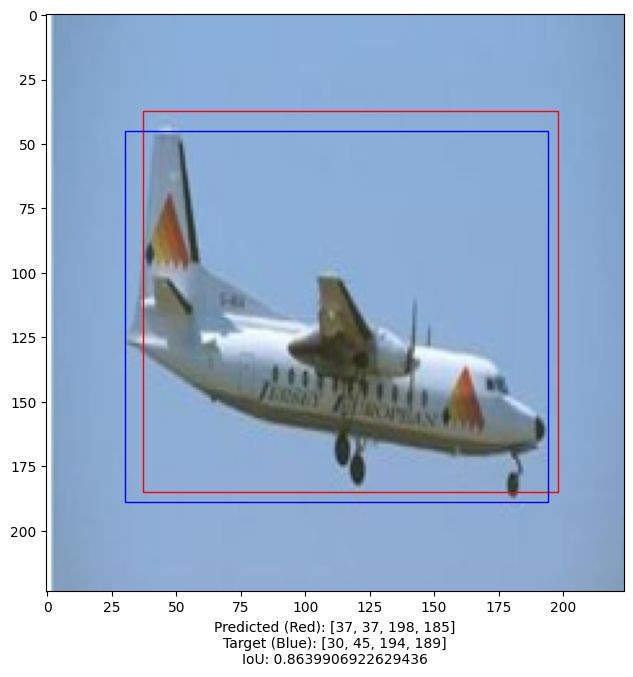

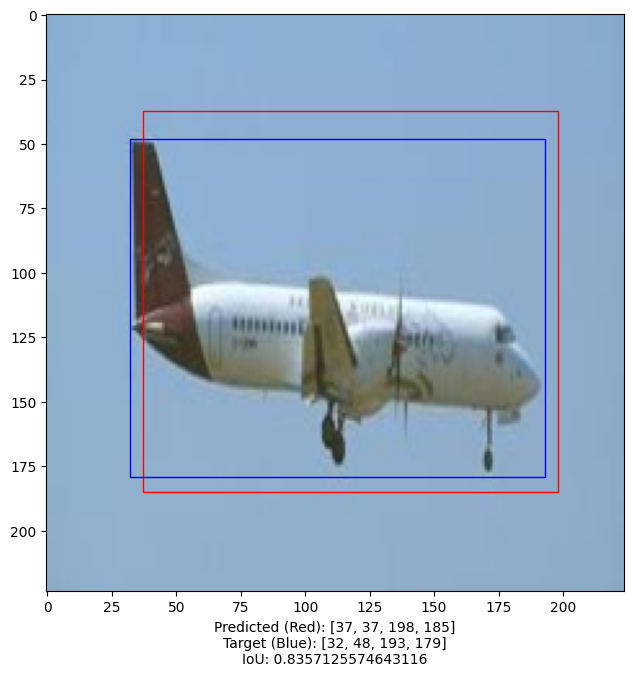

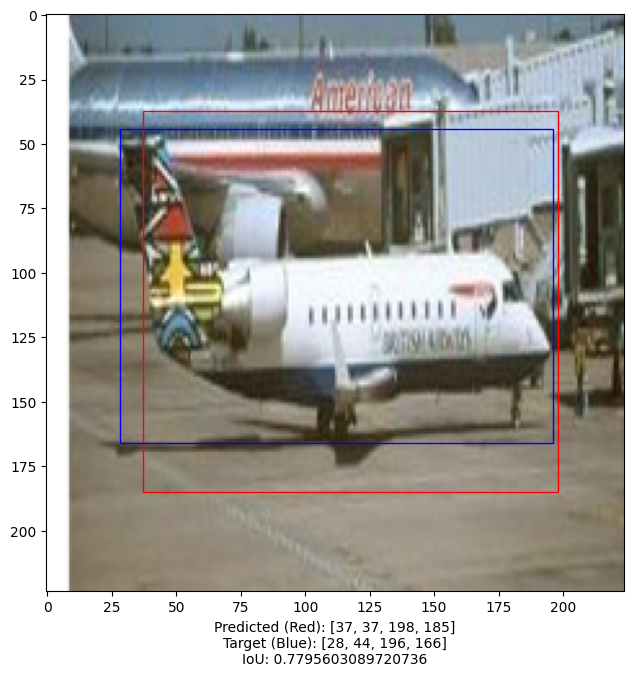

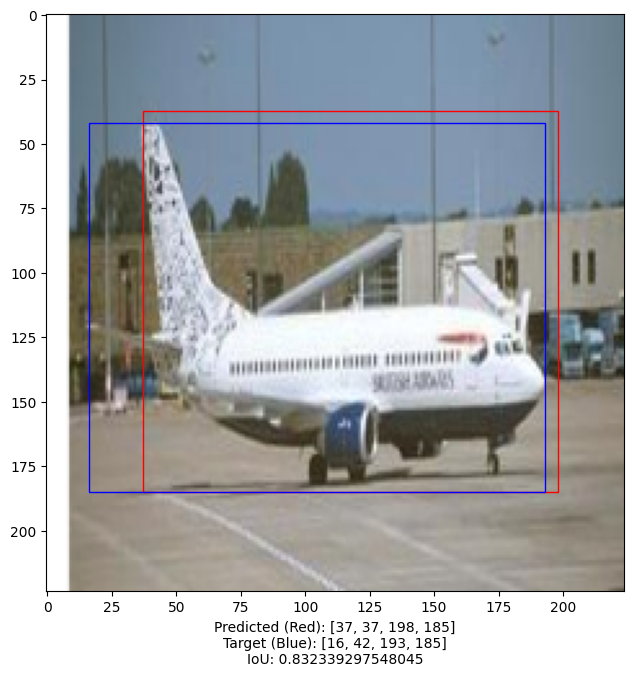

In [16]:
import matplotlib.patches as patches

max_test_imgs = 10
i, mean_iou = 0, 0

# Iteramos sobre las imágenes de test
for input_image in x_test[:max_test_imgs]:
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    im = input_image

    # Mostramos la imagen original
    ax.imshow(im.astype("uint8"))

    # Redimensionamos la imagen
    input_image = cv2.resize(input_image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    input_image = np.expand_dims(input_image, axis=0)

    # Predecimos las coordenadas de la bounding box
    preds = model.predict(input_image)[0]
    (h, w) = im.shape[0:2]
    top_left_x_pred, top_left_y_pred = int(preds[0] * w), int(preds[1] * h)
    bottom_right_x_pred, bottom_right_y_pred = int(preds[2] * w), int(preds[3] * h)
    box_predicted = [top_left_x_pred, top_left_y_pred, bottom_right_x_pred, bottom_right_y_pred]

    # Creamos el rectángulo de la bounding box predicha
    rect_pred = patches.Rectangle(
        (top_left_x_pred, top_left_y_pred),
        bottom_right_x_pred - top_left_x_pred,
        bottom_right_y_pred - top_left_y_pred,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    ax.add_patch(rect_pred)

    # Obtenemos las coordenadas de la bounding box real
    top_left_x_true, top_left_y_true = int(y_test[i][0] * w), int(y_test[i][1] * h)
    bottom_right_x_true, bottom_right_y_true = int(y_test[i][2] * w), int(y_test[i][3] * h)
    box_truth = [top_left_x_true, top_left_y_true, bottom_right_x_true, bottom_right_y_true]

    # Creamos el rectángulo de la bounding box real
    rect_true = patches.Rectangle(
        (top_left_x_true, top_left_y_true),
        bottom_right_x_true - top_left_x_true,
        bottom_right_y_true - top_left_y_true,
        facecolor="none",
        edgecolor="blue",
        linewidth=1,
    )
    ax.add_patch(rect_true)

    # Calculamos el IoU entre la bounding box predicha y la real
    iou_value = bounding_box_intersection_over_union(box_predicted, box_truth)
    mean_iou += iou_value

    ax.set_xlabel(
        "Predicted (Red): "
        + str(box_predicted)
        + "\nTarget (Blue): "
        + str(box_truth)
        + "\nIoU: "
        + str(iou_value)
    )
    i += 1

# Mostramos el IoU medio
print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

Aca podemos ver en rojo la bounding box predicha y en Azul la bounding box real, y en la parte Inferior podemos ver el valor de IoU.

## Parte 2: Segmentación semántica

La segmentación semántica es una tarea de visión por computadora en la que el objetivo es categorizar cada píxel de una imagen en una clase u objeto. El objetivo es producir un mapa de segmentación de píxeles de una imagen, donde cada píxel se asigna a una clase u objeto específico. Los modelos generalmente se evalúan con las métricas Mean Intersection-Over-Union (Mean IoU) y Precisión de píxeles.

![SS](https://uploads-ssl.webflow.com/614c82ed388d53640613982e/63f498f8d4fe7da3b3a60cc2_semantic%20segmentation%20vs%20instance%20segmentation.jpg)

### Dataset

Cityscapes [https://www.cityscapes-dataset.com/] es un dataset etiquetado de videos de automoviles conduciendo en Alemania. Esta versión es una muestra preprocesada creada como parte del paper Pix2Pix. El conjunto de datos tiene imágenes de los videos originales y las etiquetas de segmentación se muestran junto a la imagen original. Este es uno de los mejores conjuntos de datos que existen para tareas de segmentación semántica.

Este conjunto de datos tiene 2975 archivos de imágenes de entrenamiento y 500 archivos de imágenes de validación. Cada archivo de imagen tiene 256x512 píxeles y cada archivo es una composición con la foto original en la mitad izquierda de la imagen, junto con la imagen etiquetada (salida de la segmentación semántica) en la mitad derecha.

Cuenta con anotaciones de píxeles semánticas para 30 clases agrupadas en 8 categorías (superficies planas, humanos, vehículos, construcciones, objetos, naturaleza, cielo y vacío).

![Foto](cityscapes_data/val/1.jpg)

### 2.1 Librerias Utilizadas

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

In [23]:
# Si desea preprocesar las imagenes en local utilice estas funciones, de lo contrario puede utilizar los tensores que vienen en la carpeta cityscapes_data/npy/

# Funciones para procesar las imágenes desde el archivo image_processing.py
from image_processing import process_image, process_image_batch

# Librería para paralelizar el procesamiento de las imágenes
import multiprocessing

### 2.2 Funciones de ayuda

In [24]:
def preprocess(path, id_map): # Función para preprocesar las imágenes

    # Cargamos la imagen
    img = Image.open(path)

    # Separamos la imagen de la mascara y la redimensionamos
    img1 = img.crop((0, 0, 256, 256)).resize((128,128))
    img2 = img.crop((256, 0, 512, 256)).resize((128,128))

    # normalizamos la imagen
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)

    # Creamos una máscara vacía
    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)

    # Iteramos sobre la imagen para asignar un id a cada color de la mascara
    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            pixel_rgb = img2[row, col, :]
            final_key = None
            final_d = None
            for key, value in id_map.items():
                d = np.sum(np.sqrt(pow(pixel_rgb - value, 2)))
                if final_key == None:
                    final_d = d
                    final_key = key
                elif d < final_d:
                    final_d = d
                    final_key = key
            mask[row, col] = final_key

    # Añadimos una dimensión a la máscara para poder utilizarla de manera correcta en el modelo
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))

    del img2 # Eliminamos la imagen de la máscara para liberar memoria

    # Devolvemos la imagen y la máscara
    return img1, mask

In [25]:
# Función principal para preparar el conjunto de datos
def prepare_tensor_dataset(train_path, val_path):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Procesa las imágenes de entrenamiento en paralelo
    train_files = [os.path.join(train_path, file) for file in os.listdir(train_path)]
    num_cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=num_cores)
    results_train = pool.map(process_image_batch, np.array_split(train_files, num_cores))
    pool.close()
    pool.join()

    # Guardamos las imágenes y las máscaras en listas
    for result_batch in results_train:
        for img, mask in result_batch:
            X_train.append(img)
            Y_train.append(mask)

    # Procesa las imágenes de validación en paralelo
    val_files = [os.path.join(val_path, file) for file in os.listdir(val_path)]
    pool = multiprocessing.Pool(processes=num_cores)
    results_val = pool.map(process_image_batch, np.array_split(val_files, num_cores))
    pool.close()
    pool.join()

    # Guardamos las imágenes y las máscaras en listas
    for result_batch in results_val:
        for img, mask in result_batch:
            X_val.append(img)
            Y_val.append(mask)

    return X_train, Y_train, X_val, Y_val

### 2.3 Mapa de Segmentación

In [26]:
id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

# Número de clases
num_classes = len(id_map.keys())

### 2.4.1 Procesamiento de las Imágenes

Si va a preprocesar las imagenes en local corra las siguientes celdas, sino puede saltar a la celda 1.4.3 y cargar los tensores directamente ya que el preprocesamiento demora bastante.

In [ ]:
X_train, Y_train, X_valid, Y_valid = prepare_tensor_dataset("cityscapes_data/train/", "cityscapes_data/val/")

In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

#### 2.4.2 Guardamos los tensores para no tener que volver a procesarlos

In [ ]:
np.save('cityscapes_data/npy/X_train.npy', X_train)
np.save('cityscapes_data/npy/Y_train.npy', Y_train)
np.save('cityscapes_data/npy/X_valid.npy', X_valid)
np.save('cityscapes_data/npy/Y_valid.npy', Y_valid)

#### 2.4.3 Cargamos los tensores preprocesados

In [ ]:
X_train = np.load('cityscapes_data/npy/X_train.npy')
Y_train = np.load('cityscapes_data/npy/Y_train.npy')
X_valid = np.load('cityscapes_data/npy/X_valid.npy')
Y_valid = np.load('cityscapes_data/npy/Y_valid.npy')

### 2.5 Metricas y Callbacks

In [ ]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU): # Clase para calcular el Mean IoU
  def __init__(self, y_true=None, y_pred=None, num_classes=None, name=None, dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None): # Función para actualizar el estado del Mean IoU
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback): # Clase para visualizar las predicciones del modelo

    def __init__(self, file_path, **kwargs):
        super().__init__(**kwargs)
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None): # Función para visualizar las predicciones del modelo al final de cada época
        #plt.style.use("default")
        img, mask = preprocess(self.file_path, id_map)
        img = np.array(img)
        img = np.reshape(img, (1, 128, 128, 3))
        pred = model.predict(img)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 128))
        fig, axes = plt.subplots(nrows = 1, ncols = 2)
        axes[0].imshow(mask)
        axes[0].set_title("Original Mask")
        axes[1].imshow(y_pred)
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

def plot_history(history): # Función para visualizar las métricas de entrenamiento y validación
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
  sns.lineplot

  #training
  sns.lineplot(history.history["loss"], ax = axes[0], label="Training Loss")
  sns.lineplot(history.history["accuracy"], ax = axes[1], label="Training Accuracy")
  sns.lineplot(history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

  # Validacion
  sns.lineplot(history.history["val_loss"], ax = axes[0], label="Validation Loss")
  sns.lineplot(history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
  sns.lineplot(history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")

  axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")

  axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Accuracy")

  axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
  axes[2].set_xlabel("Epoch")
  axes[2].set_ylabel("Mean IOU")
  plt.tight_layout()
  plt.show()

### 2.6 Modelos para Segmentación Semántica

En esta sección se presentaran 2 modelos para segmentacion Semantica, el primero ya esta implementado y sirve como ejemplo de prueba, ya que para el segundo modelo ustedes deberan completar el modelo y asegurarse de que funcione de manera correcta.

#### 2.6.1 PSPnet

PSPNet [https://www.computer.org/csdl/proceedings-article/cvpr/2017/0457g230/12OmNvrMUeP], o Pyramid Scene Parsing Network, es un modelo de segmentación semántica que utiliza un módulo de parsing piramidal.

Dada una imagen de entrada, PSPNet utiliza una CNN dilatada previamente entrenada para extraer los feature maps. El tamaño final feature map es 1/8 de la imagen de entrada. En la parte superior del feature map, utilizamos un modulo de pooling piramidal (pyramid pooling module) para recopilar información de contexto.
Usando una pirámide de 4 niveles, los kernels cubren la totalidad, la mitad y pequeñas porciones de la imagen.
Después se combinan los 4 feature maps para generar el prior global, y este se concatena con el feature map original, y se pasa por una capa de convolución para generar el mapa de predicción final.

![pspnet](https://production-media.paperswithcode.com/methods/new_pspnet-eps-converted-to.jpg)

In [ ]:
def conv_block(X,filters):
    f1,f2,f3 = filters
    X_skip = X

    # block_a
    X = tf.keras.layers.Convolution2D(filters=f1, kernel_size=(1,1), dilation_rate=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.ReLU()(X)

    # block_b
    X = tf.keras.layers.Convolution2D(filters=f2, kernel_size=(3,3), dilation_rate=(2,2), padding='same', kernel_initializer='he_normal')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.ReLU()(X)

    # block_c
    X = tf.keras.layers.Convolution2D(filters=f3, kernel_size=(1,1), dilation_rate=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    # skip_conv
    X_skip = tf.keras.layers.Convolution2D(filters=f3, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X_skip)
    X_skip = tf.keras.layers.BatchNormalization()(X_skip)

    # block_c + skip_conv
    X = tf.keras.layers.Add()([X,X_skip])
    X = tf.keras.layers.ReLU()(X)

    return X

def base_feature_maps(input_layer):
    # block_1
    base = conv_block(input_layer,[32,32,64])

    # block_2
    base = conv_block(base,[64,64,128])

    # block_3
    base = conv_block(base,[128,128,256])

    return base

def pyramid_feature_maps(input_layer):
    base = base_feature_maps(input_layer)

    # red
    red = tf.keras.layers.GlobalAveragePooling2D()(base)
    red = tf.keras.layers.Reshape((1,1,256))(red)
    red = tf.keras.layers.Convolution2D(filters=64, kernel_size=(1,1))(red)
    red = tf.keras.layers.UpSampling2D(size=128, interpolation='bilinear')(red)

    # yellow
    yellow = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(base)
    yellow = tf.keras.layers.Convolution2D(filters=64, kernel_size=(1,1))(yellow)
    yellow = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(yellow)

    # blue
    blue = tf.keras.layers.AveragePooling2D(pool_size=(4,4))(base)
    blue = tf.keras.layers.Convolution2D(filters=64, kernel_size=(1,1))(blue)
    blue = tf.keras.layers.UpSampling2D(size=4, interpolation='bilinear')(blue)

    # green
    green = tf.keras.layers.AveragePooling2D(pool_size=(8,8))(base)
    green = tf.keras.layers.Convolution2D(filters=64, kernel_size=(1,1))(green)
    green = tf.keras.layers.UpSampling2D(size=8, interpolation='bilinear')(green)

    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer, num_classes):
    x = pyramid_feature_maps(input_layer)
    x = tf.keras.layers.Convolution2D(filters=3, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size = (3, 3), padding = "same", strides = 1, activation = "softmax")(x)

    return outputs

def pspnet(input_shape, num_classes):
    input_layer = tf.keras.layers.Input(shape = input_shape)
    output_layer = last_conv_module(input_layer, num_classes)
    model = tf.keras.Model(inputs=input_layer,outputs=output_layer)

    return model

In [ ]:
model = pspnet(input_shape=X_train.shape[1:], num_classes=num_classes)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
viz_callback = VizCallback("cityscapes_data/val/106.jpg")

In [ ]:
history = model.fit(x=X_train, y=Y_train, epochs = 100, batch_size = 16, validation_data = (X_valid, Y_valid), callbacks=[early_stopping, viz_callback])

In [ ]:
plot_history(history)

In [ ]:
def plot_validation_preds(model, id_map):
    plt.style.use("default")
    for i in os.listdir("cityscapes_data/val/")[:3]:
        img, mask = preprocess(f"cityscapes_data/val/{i}", id_map)
        img = np.array(img)
        img = np.reshape(img, (1, 128, 128, 3))
        pred = model.predict(img)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 128))
        fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
        img = np.reshape(img, (128, 128, 3))
        axes[0].imshow(img)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        axes[1].imshow(mask, cmap="viridis")
        axes[1].set_title("Original Mask")
        axes[1].axis("off")
        axes[2].imshow(y_pred, cmap="viridis")
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

In [ ]:
plot_validation_preds(model, id_map)

#### 2.6.2 U-NET

U-Net [https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28] es una arquitectura para segmentación semántica. Consta de una rama de contracción y una rama de expansión. La ruta de contratación sigue la arquitectura típica de una red convolucional. Consiste en la aplicación repetida de dos convoluciones de 3x3, cada una seguida por una ReLU y una operación de max pooling de 2x2 con stride 2 para reducir la resolución.

En cada paso de reducción de resolución duplicamos el número de canales. Cada paso en la ruta expansiva consiste en un muestreo superior del feature map, seguido de un upsampling2D de 2x2 que reduce a la mitad el número de canales de características, despues mediante skip connections concatenamos las capas residuales correspondientes y dos convoluciones 3x3, cada una seguida de una ReLU. En la capa final, se utiliza una convolución de 1x1 para asignar cada pixel al número deseado de clases


<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png" alt="unet" width="600"/>

In [ ]:
def get_unet_model(img_shape, num_classes):
    #Capa de Input
    inputs = tf.keras.layers.Input(shape = img_shape)

    #Primer Downsample
    feature_map_1 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation='relu')(inputs)
    feature_map_1 = tf.keras.layers.BatchNormalization()(feature_map_1)
    feature_map_1 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(feature_map_1) #Usar despues en residual connection 4
    maxpooling_1 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(feature_map_1)
    maxpooling_1 = tf.keras.layers.Dropout(0.2)(maxpooling_1)

    #Segundo Downsample
    feature_map_2 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1 , activation = "relu")(maxpooling_1)
    feature_map_2 = tf.keras.layers.BatchNormalization()(feature_map_2)
    feature_map_2 = tf.keras.layers.Conv2D(128,kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(feature_map_2) #Usar despues en residual connection 3
    maxpooling_2 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(feature_map_2)
    maxpooling_2 = tf.keras.layers.Dropout(0.2)(maxpooling_2)

    #Tercer Downsample
    feature_map_3 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1 , activation = "relu")(maxpooling_2)
    feature_map_3 = tf.keras.layers.BatchNormalization()(feature_map_3)
    feature_map_3 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1 , activation = "relu")(feature_map_3) #Usar despues en residual connection 2
    maxpooling_3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(feature_map_3)
    maxpooling_3 = tf.keras.layers.Dropout(0.2)(maxpooling_3)

    #Cuarto Downsample
    feature_map_4 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 , activation = "relu")(maxpooling_3)
    feature_map_4 = tf.keras.layers.BatchNormalization()(feature_map_4)
    feature_map_4 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 , activation = "relu")(feature_map_4) #Usar despues en residual connection 2
    maxpooling_4 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(feature_map_4)
    maxpooling_4 = tf.keras.layers.Dropout(0.2)(maxpooling_4)

    #Quinto Downsample
    feature_map_5 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(maxpooling_4)
    feature_map_5 = tf.keras.layers.BatchNormalization()(feature_map_5)
    feature_map_5 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(feature_map_5)

    #Primer Upsample
    upsample_1 = tf.keras.layers.UpSampling2D(size = (2, 2))(feature_map_5)
    upsample_1 = tf.keras.layers.Dropout(0.2)(upsample_1)
    upsample_1 = tf.keras.layers.Concatenate()([upsample_1, feature_map_4]) #Residual Connection 1
    upsample_1 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(upsample_1)
    upsample_1 = tf.keras.layers.BatchNormalization()(upsample_1)
    upsample_1 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(upsample_1)

    #Segundo Upsample
    upsample_2 = tf.keras.layers.UpSampling2D(size = (2, 2))(upsample_1)
    upsample_2 = tf.keras.layers.Dropout(0.2)(upsample_2)
    upsample_2 = tf.keras.layers.Concatenate()([upsample_2, feature_map_3]) #Residual Connection 2
    upsample_2 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(upsample_2)
    upsample_2 = tf.keras.layers.BatchNormalization()(upsample_2)
    upsample_2 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(upsample_2)

    #Tercer Upsample
    upsample_3 = tf.keras.layers.UpSampling2D(size = (2, 2))(upsample_2)
    upsample_3 = tf.keras.layers.Dropout(0.2)(upsample_3)
    upsample_3 = tf.keras.layers.Concatenate()([upsample_3, feature_map_2]) #Residual Connection 2
    upsample_3 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(upsample_3)
    upsample_3 = tf.keras.layers.BatchNormalization()(upsample_3)
    upsample_3 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(upsample_3)

    #Cuarto Upsample
    upsample_4 = tf.keras.layers.UpSampling2D(size = (2, 2))(upsample_3)
    upsample_4 = tf.keras.layers.Dropout(0.2)(upsample_4)
    upsample_4 = tf.keras.layers.Concatenate()([upsample_4, feature_map_1]) #Residual Connection 2
    upsample_4 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(upsample_4)
    upsample_4 = tf.keras.layers.BatchNormalization()(upsample_4)
    upsample_4 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(upsample_4)

    #Capa de Salida
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size = (1, 1), padding = "same", strides = 1, activation = "softmax")(upsample_4)

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])

    return model

In [ ]:
model = get_unet_model(img_shape=X_train.shape[1:], num_classes=num_classes)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

### 2.7 Entrenamiento

#### 2.7.1 Hiperparámetros

In [ ]:
unet_opt = tf.keras.optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=0.004,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    jit_compile=True,
    name='AdamW',
)

unet_loss = tf.keras.losses.SparseCategoricalCrossentropy(
    reduction=losses_utils.ReductionV2.AUTO,
    name='sparse_categorical_crossentropy'
) # Utilizar la función de pérdida "sparse categorical crossentropy"

unet_metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")]

In [ ]:
model.compile(loss = unet_loss, optimizer = unet_opt, metrics = unet_metrics)

#### 2.7.2 Callbacks

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

viz_callback = VizCallback("cityscapes_data/val/106.jpg")

unet_callbacks = [early_stopping, viz_callback] # Utilizar los callbacks de early stopping y viz_callback en una lista para pasarselos al modelo

#### 2.7.3 Entrenando U-Net

In [ ]:
history = model.fit(x=X_train, y=Y_train, epochs = 100, batch_size = 16, validation_data = (X_valid, Y_valid), callbacks=unet_callbacks)

### 2.8 Resultados del Entrenamiento

In [ ]:
plot_history(history)

### 2.9 Prediccion en el Set de test

In [ ]:
def plot_validation_preds(model, id_map):
    plt.style.use("default")
    for i in os.listdir("cityscapes_data/val/")[:3]:
        img, mask = preprocess(f"cityscapes_data/val/{i}", id_map)
        img = np.array(img)
        img = np.reshape(img, (1, 128, 128, 3))
        pred = model.predict(img)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 128))
        fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
        img = np.reshape(img, (128, 128, 3))
        axes[0].imshow(img)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        axes[1].imshow(mask, cmap="viridis")
        axes[1].set_title("Original Mask")
        axes[1].axis("off")
        axes[2].imshow(y_pred, cmap="viridis")
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
plot_validation_preds(model, id_map)